In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib.pylab import mpl
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
from keras.layers import LeakyReLU
from tcn import TCN,tcn_full_summary
from sklearn.metrics import mean_squared_error # 均方误差
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from tensorflow.keras import Input, Model,Sequential
import sklearn.metrics as skm


In [2]:
mpl.rcParams['font.sans-serif'] = ['SimHei']   #显示中文
mpl.rcParams['axes.unicode_minus']=False       #显示负号


In [3]:
data=pd.read_csv('mock_kaggle.csv',encoding ='gbk',parse_dates=['datetime'])
Date=pd.to_datetime(data.datetime)
data['date'] = Date.map(lambda x: x.strftime('%Y-%m-%d'))
datanew=data.set_index(Date)
series = pd.Series(datanew['股票'].values, index=datanew['date'])


In [5]:
import tushare as ts
pro = ts.pro_api('e6cde7f6165daeaa49d539e2de4b4725944d64c70e1685e563eaebe8')
def get_funds_data(code):    
    df = pro.fund_daily(**{
        "trade_date": "",
        "start_date":20180101,
        "end_date": "",
        "ts_code": code,
        "limit": "",
        "offset": ""
    }, fields=[
        "ts_code",
        "trade_date",
        "pre_close",
        "open",
        "high",
        "low",
        "close",
        "change",
        "pct_chg",
        "vol",
        "amount"
    ])
    return df

df=get_funds_data("159804.SZ")
df=df.sort_values('trade_date')


In [3]:
series=df['close']

SyntaxError: invalid syntax (3161522930.py, line 1)

In [117]:
df=pd.read_excel('512660.xls')
series=df['收盘价(元)']

In [69]:
df

,代码,简称,时间,开盘价(元),收盘价(元),最高价(元),最低价(元)
0,159928.SZ,消费ETF,2013-09-16,1.001,0.987,1.002,0.981
1,159928.SZ,消费ETF,2013-09-17,0.985,0.971,0.988,0.969
2,159928.SZ,消费ETF,2013-09-18,0.966,0.983,0.983,0.962
3,159928.SZ,消费ETF,2013-09-23,0.984,0.996,0.998,0.978
4,159928.SZ,消费ETF,2013-09-24,0.995,1.005,1.007,0.989
...,...,...,...,...,...,...,...
2302,159928.SZ,消费ETF,2023-03-07,1.083,1.062,1.085,1.061
2303,159928.SZ,消费ETF,2023-03-08,1.061,1.054,1.064,1.050
2304,159928.SZ,消费ETF,2023-03-09,1.053,1.050,1.059,1.039
2305,159928.SZ,消费ETF,2023-03-10,1.044,1.034,1.050,1.034


In [71]:
series


0       0.987
1       0.971
2       0.983
3       0.996
4       1.005
        ...  
2302    1.062
2303    1.054
2304    1.050
2305    1.034
2306    1.054
Name: 收盘价(元), Length: 2307, dtype: float64

In [118]:
dataframe1 = pd.DataFrame()
num_hour = 16
for i in range(num_hour,0,-1):
    dataframe1['t-'+str(i)] = series.shift(i)
dataframe1['t'] = series.values
dataframe3=dataframe1.dropna()
dataframe3.index=range(len(dataframe3))


In [73]:
dataframe3


,t-16,t-15,t-14,t-13,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,0.987,0.971,0.983,0.996,1.005,1.003,1.007,1.002,1.016,1.028,1.035,1.036,1.049,1.068,1.082,1.061,1.058
1,0.971,0.983,0.996,1.005,1.003,1.007,1.002,1.016,1.028,1.035,1.036,1.049,1.068,1.082,1.061,1.058,1.063
2,0.983,0.996,1.005,1.003,1.007,1.002,1.016,1.028,1.035,1.036,1.049,1.068,1.082,1.061,1.058,1.063,1.101
3,0.996,1.005,1.003,1.007,1.002,1.016,1.028,1.035,1.036,1.049,1.068,1.082,1.061,1.058,1.063,1.101,1.089
4,1.005,1.003,1.007,1.002,1.016,1.028,1.035,1.036,1.049,1.068,1.082,1.061,1.058,1.063,1.101,1.089,1.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2286,1.104,1.100,1.093,1.091,1.085,1.104,1.098,1.101,1.090,1.079,1.086,1.089,1.098,1.093,1.089,1.085,1.062
2287,1.100,1.093,1.091,1.085,1.104,1.098,1.101,1.090,1.079,1.086,1.089,1.098,1.093,1.089,1.085,1.062,1.054
2288,1.093,1.091,1.085,1.104,1.098,1.101,1.090,1.079,1.086,1.089,1.098,1.093,1.089,1.085,1.062,1.054,1.050
2289,1.091,1.085,1.104,1.098,1.101,1.090,1.079,1.086,1.089,1.098,1.093,1.089,1.085,1.062,1.054,1.050,1.034


In [119]:
# pot=int(len(dataframe3)*0.8)
#pd.DataFrame(np.random.shuffle(dataframe3.values))  #shuffle
pot=len(dataframe3)-25
train=dataframe3[:pot]
test=dataframe3[pot:]
scaler = MinMaxScaler(feature_range=(0, 1)).fit(train)
#scaler = preprocessing.StandardScaler().fit(train)
train_norm=pd.DataFrame(scaler.fit_transform(train))
test_norm=pd.DataFrame(scaler.transform(test))


In [75]:
train_norm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.025343,0.022248,0.024570,0.027085,0.028826,0.028439,0.029213,0.028245,0.030954,0.033275,0.034630,0.034823,0.037338,0.041014,0.043722,0.039660,0.039079
1,0.022248,0.024570,0.027085,0.028826,0.028439,0.029213,0.028245,0.030954,0.033275,0.034630,0.034823,0.037338,0.041014,0.043722,0.039660,0.039079,0.040046
2,0.024570,0.027085,0.028826,0.028439,0.029213,0.028245,0.030954,0.033275,0.034630,0.034823,0.037338,0.041014,0.043722,0.039660,0.039079,0.040046,0.047398
3,0.027085,0.028826,0.028439,0.029213,0.028245,0.030954,0.033275,0.034630,0.034823,0.037338,0.041014,0.043722,0.039660,0.039079,0.040046,0.047398,0.045076
4,0.028826,0.028439,0.029213,0.028245,0.030954,0.033275,0.034630,0.034823,0.037338,0.041014,0.043722,0.039660,0.039079,0.040046,0.047398,0.045076,0.038692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,0.036371,0.032695,0.032501,0.039079,0.039079,0.042175,0.043142,0.042175,0.041014,0.046624,0.050880,0.048559,0.046624,0.045850,0.045463,0.047591,0.043916
2262,0.032695,0.032501,0.039079,0.039079,0.042175,0.043142,0.042175,0.041014,0.046624,0.050880,0.048559,0.046624,0.045850,0.045463,0.047591,0.043916,0.045657
2263,0.032501,0.039079,0.039079,0.042175,0.043142,0.042175,0.041014,0.046624,0.050880,0.048559,0.046624,0.045850,0.045463,0.047591,0.043916,0.045657,0.046624
2264,0.039079,0.039079,0.042175,0.043142,0.042175,0.041014,0.046624,0.050880,0.048559,0.046624,0.045850,0.045463,0.047591,0.043916,0.045657,0.046624,0.044496


In [76]:
test

,t-16,t-15,t-14,t-13,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
2266,1.074,1.079,1.074,1.068,1.097,1.119,1.107,1.097,1.093,1.091,1.102,1.083,1.092,1.097,1.086,1.067,1.068
2267,1.079,1.074,1.068,1.097,1.119,1.107,1.097,1.093,1.091,1.102,1.083,1.092,1.097,1.086,1.067,1.068,1.059
2268,1.074,1.068,1.097,1.119,1.107,1.097,1.093,1.091,1.102,1.083,1.092,1.097,1.086,1.067,1.068,1.059,1.078
2269,1.068,1.097,1.119,1.107,1.097,1.093,1.091,1.102,1.083,1.092,1.097,1.086,1.067,1.068,1.059,1.078,1.080
2270,1.097,1.119,1.107,1.097,1.093,1.091,1.102,1.083,1.092,1.097,1.086,1.067,1.068,1.059,1.078,1.080,1.104
2271,1.119,1.107,1.097,1.093,1.091,1.102,1.083,1.092,1.097,1.086,1.067,1.068,1.059,1.078,1.080,1.104,1.100
2272,1.107,1.097,1.093,1.091,1.102,1.083,1.092,1.097,1.086,1.067,1.068,1.059,1.078,1.080,1.104,1.100,1.093
2273,1.097,1.093,1.091,1.102,1.083,1.092,1.097,1.086,1.067,1.068,1.059,1.078,1.080,1.104,1.100,1.093,1.091
2274,1.093,1.091,1.102,1.083,1.092,1.097,1.086,1.067,1.068,1.059,1.078,1.080,1.104,1.100,1.093,1.091,1.085
2275,1.091,1.102,1.083,1.092,1.097,1.086,1.067,1.068,1.059,1.078,1.080,1.104,1.100,1.093,1.091,1.085,1.104


In [77]:
dataframe3

,t-16,t-15,t-14,t-13,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,0.987,0.971,0.983,0.996,1.005,1.003,1.007,1.002,1.016,1.028,1.035,1.036,1.049,1.068,1.082,1.061,1.058
1,0.971,0.983,0.996,1.005,1.003,1.007,1.002,1.016,1.028,1.035,1.036,1.049,1.068,1.082,1.061,1.058,1.063
2,0.983,0.996,1.005,1.003,1.007,1.002,1.016,1.028,1.035,1.036,1.049,1.068,1.082,1.061,1.058,1.063,1.101
3,0.996,1.005,1.003,1.007,1.002,1.016,1.028,1.035,1.036,1.049,1.068,1.082,1.061,1.058,1.063,1.101,1.089
4,1.005,1.003,1.007,1.002,1.016,1.028,1.035,1.036,1.049,1.068,1.082,1.061,1.058,1.063,1.101,1.089,1.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2286,1.104,1.100,1.093,1.091,1.085,1.104,1.098,1.101,1.090,1.079,1.086,1.089,1.098,1.093,1.089,1.085,1.062
2287,1.100,1.093,1.091,1.085,1.104,1.098,1.101,1.090,1.079,1.086,1.089,1.098,1.093,1.089,1.085,1.062,1.054
2288,1.093,1.091,1.085,1.104,1.098,1.101,1.090,1.079,1.086,1.089,1.098,1.093,1.089,1.085,1.062,1.054,1.050
2289,1.091,1.085,1.104,1.098,1.101,1.090,1.079,1.086,1.089,1.098,1.093,1.089,1.085,1.062,1.054,1.050,1.034


In [78]:
test_norm.shape,train_norm.shape


((25, 17), (2266, 17))

In [120]:
X_train=train_norm.iloc[:,:-1]
X_test=test_norm.iloc[:,:-1]
Y_train=train_norm.iloc[:,-1:]
Y_test=test_norm.iloc[:,-1:]


In [121]:
source_x_train=X_train
source_x_test=X_test
X_train=X_train.values.reshape([X_train.shape[0],1,X_train.shape[1]]) 
X_test=X_test.values.reshape([X_test.shape[0],1,X_test.shape[1]])  
Y_train=Y_train.values
Y_test=Y_test.values


In [122]:
X_train.shape,Y_train.shape

((1561, 1, 16), (1561, 1))

In [123]:
Y_train

array([[0.48390805],
       [0.47931034],
       [0.46781609],
       ...,
       [0.61724138],
       [0.63333333],
       [0.62298851]])

In [124]:
X_test.shape,Y_test.shape


((25, 1, 16), (25, 1))

In [125]:
def scheduler(epoch):
    # 每隔50个epoch，学习率减小为原来的1/10
    if epoch % 50 == 0 and epoch != 0:
        lr = K.get_value(tcn.optimizer.lr)
        if lr>1e-5:
            K.set_value(tcn.optimizer.lr, lr * 0.1)
            print("lr changed to {}".format(lr * 0.1))
    return K.get_value(tcn.optimizer.lr)

reduce_lr = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='loss', 
                               patience=20, 
                               min_delta=1e-5,
                               mode='auto',
                               restore_best_weights=False,#是否从具有监测数量的最佳值的时期恢复模型权重
                               verbose=2)


In [131]:
batch_size=None
timesteps=X_train.shape[1]
input_dim=X_train.shape[2] #输入维数
tcn = Sequential()
input_layer =Input(batch_shape=(batch_size,timesteps,input_dim))
tcn.add(input_layer)
tcn.add(TCN(nb_filters=64, #在卷积层中使用的过滤器数。可以是列表。
        kernel_size=3, #在每个卷积层中使用的内核大小。
        nb_stacks=1,   #要使用的残差块的堆栈数。
        dilations=[2 ** i for i in range(6)], #扩张列表。示例为：[1、2、4、8、16、32、64]。
        #用于卷积层中的填充,值为'causal' 或'same'。
        #“causal”将产生因果（膨胀的）卷积，即output[t]不依赖于input[t+1：]。当对不能违反时间顺序的时序信号建模时有用。
        #“same”代表保留边界处的卷积结果，通常会导致输出shape与输入shape相同。
        padding='causal',
        use_skip_connections=True, #是否要添加从输入到每个残差块的跳过连接。
        dropout_rate=0.1, #在0到1之间浮动。要下降的输入单位的分数。
        return_sequences=False,#是返回输出序列中的最后一个输出还是完整序列。
        activation='relu', #残差块中使用的激活函数 o = Activation(x + F(x)).
        kernel_initializer='he_normal', #内核权重矩阵（Conv1D）的初始化程序。
        use_batch_norm=True, #是否在残差层中使用批处理规范化。
        use_layer_norm=True, #是否在残差层中使用层归一化。
        name='tcn' #使用多个TCN时，要使用唯一的名称
        ))
#tcn.add(tf.keras.layers.Dropout(0.5))
tcn.add(tf.keras.layers.Dense(64))
tcn.add(tf.keras.layers.LeakyReLU(alpha=0.3))
tcn.add(tf.keras.layers.Dense(32))
tcn.add(tf.keras.layers.LeakyReLU(alpha=0.3))
tcn.add(tf.keras.layers.Dense(16))
tcn.add(tf.keras.layers.LeakyReLU(alpha=0.3))
tcn.add(tf.keras.layers.Dense(1))
tcn.add(tf.keras.layers.LeakyReLU(alpha=0.3))
tcn.compile('adam', loss='mse', metrics=['accuracy'])
tcn.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 64)                143168    
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 32)                0         
                                                                 
 dense_35 (Dense)            (None, 16)                528       
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 16)               

In [132]:
history=tcn.fit(X_train,Y_train, epochs=80,batch_size=32,callbacks=[reduce_lr])


Epoch 1/80
49/49 [==============================] - 3s 12ms/step - loss: 0.1767 - accuracy: 0.0013 - lr: 0.0010
Epoch 2/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0336 - accuracy: 0.0013 - lr: 0.0010
Epoch 3/80
49/49 [==============================] - 1s 16ms/step - loss: 0.0248 - accuracy: 0.0013 - lr: 0.0010
Epoch 4/80
49/49 [==============================] - 1s 18ms/step - loss: 0.0181 - accuracy: 0.0013 - lr: 0.0010
Epoch 5/80
49/49 [==============================] - 1s 16ms/step - loss: 0.0154 - accuracy: 0.0013 - lr: 0.0010
Epoch 6/80
49/49 [==============================] - 1s 12ms/step - loss: 0.0126 - accuracy: 0.0013 - lr: 0.0010
Epoch 7/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0126 - accuracy: 0.0013 - lr: 0.0010
Epoch 8/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0137 - accuracy: 0.0013 - lr: 0.0010
Epoch 9/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0119 - accuracy: 0.0013 - lr:

49/49 [==============================] - 1s 11ms/step - loss: 0.0039 - accuracy: 0.0013 - lr: 1.0000e-04
Epoch 73/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0031 - accuracy: 0.0013 - lr: 1.0000e-04
Epoch 74/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0032 - accuracy: 0.0013 - lr: 1.0000e-04
Epoch 75/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0036 - accuracy: 0.0013 - lr: 1.0000e-04
Epoch 76/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0036 - accuracy: 0.0013 - lr: 1.0000e-04
Epoch 77/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0030 - accuracy: 0.0013 - lr: 1.0000e-04
Epoch 78/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0029 - accuracy: 0.0013 - lr: 1.0000e-04
Epoch 79/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0031 - accuracy: 0.0013 - lr: 1.0000e-04
Epoch 80/80
49/49 [==============================] - 1s 11ms/step - loss: 0.

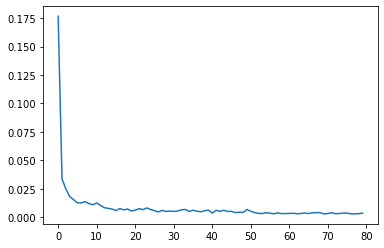

In [133]:
history.history.keys() #查看history中存储了哪些参数
plt.plot(history.epoch,history.history.get('loss')) #画出随着epoch增大loss的变化图
#plt.plot(history.epoch,history.history.get('acc'))#画出随着epoch增大准确率的变化图


In [134]:
#history.history.get('loss')

In [135]:
predict = tcn.predict(X_test)
real_predict=scaler.inverse_transform(np.concatenate((source_x_test,predict),axis=1))
real_y=scaler.inverse_transform(np.concatenate((source_x_test,Y_test),axis=1))
real_predict=real_predict[:,-1]
real_y=real_y[:,-1]


1/1 [==============================] - 0s 381ms/step


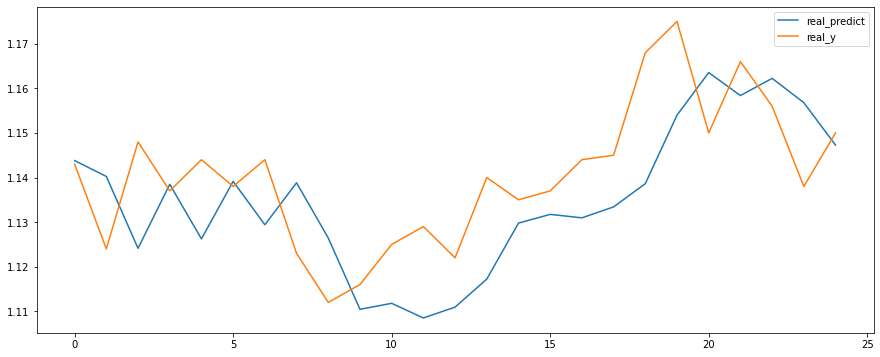

In [136]:
plt.figure(figsize=(15,6))
bwith = 0.75 #边框宽度设置为2
ax = plt.gca()#获取边框
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
plt.plot(real_predict,label='real_predict')
plt.plot(real_y,label='real_y')
#plt.plot(real_y*(1+0.15),label='15%上限',linestyle='--',color='green')
#plt.plot(real_y*(1+0.1),label='10%上限',linestyle='--')
#plt.plot(real_y*(1-0.1),label='10%下限',linestyle='--')
#plt.plot(real_y*(1-0.15),label='15%下限',linestyle='--',color='green')
#plt.fill_between(range(0,12),real_y*(1+0.1),real_y*(1-0.1),color='gray',alpha=0.2)
plt.legend()
plt.show()


In [137]:
RMSE=round(mean_squared_error(Y_test,predict),4)
MAPE = skm.mean_absolute_percentage_error(Y_test,predict)
MAE = skm.mean_absolute_error(Y_test,predict)
RMSE = skm.mean_squared_error(Y_test,predict,squared=False)
print("MAPE:"+str(round(MAPE,4)*100)+"%")
print("RMSE"+str(round(RMSE,4)))
print("MAE"+str(round(MAE,4)))

MAPE:2.34%
RMSE0.0169
MAE0.0144


In [34]:
RMSE=round(mean_squared_error(Y_test,predict),4)
RMSE

0.0004

In [63]:
from sklearn.metrics import r2_score
round(r2_score(real_y,real_predict),4)


0.1284

In [64]:
per_real_loss=(real_y-real_predict)/real_y
avg_per_real_loss=sum(abs(per_real_loss))/len(per_real_loss)
print(avg_per_real_loss)


0.01826533285457114


In [65]:
#计算指定置信水平下的预测准确率
#level为小数
def comput_acc(real,predict,level):
    num_error=0
    for i in range(len(real)):
        if abs(real[i]-predict[i])/real[i]>level:
            num_error+=1
    return 1-num_error/len(real)


In [66]:
comput_acc(real_y,real_predict,0.2),comput_acc(real_y,real_predict,0.15),comput_acc(real_y,real_predict,0.1)


(1.0, 1.0, 1.0)

In [ ]:
1